# Task 2: Quantitative Analysis with TA-Lib & PyNance

In this notebook, we calculate quantitative indicators on stock price data.
We will:

1. Load stock price data 
2. Clean and prepare the data for analysis.
3. Compute basic indicators:
   - Moving Averages (MA)
   - Relative Strength Index (RSI)
   - Moving Average Convergence Divergence (MACD)
4. Use PyNance to compute financial metrics (returns, volatility).
5. Visualize all indicators.


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib as ta
import pynance as py
import os


### Loading the CSVs

In [46]:
data_path = r"C:\KAIM\week-1\financial-news-sentiment-analysis\data\stock_data"   # Change if needed

stock_files = [f for f in os.listdir(data_path) if f.endswith(".csv")]
stock_files
stocks = {}

for filename in stock_files:
    symbol = filename.replace(".csv", "")
    df = pd.read_csv(os.path.join(data_path, filename), parse_dates=["Date"])
    df = df.sort_values("Date").set_index("Date")
    df = df.rename(columns=str.lower)
    stocks[symbol] = df

stocks.keys()

dict_keys(['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA'])

### Data Checking & Validation

In [47]:
for symbol, df in stocks.items():
    print(f"\n===== {symbol} =====")
    print("Shape:", df.shape)
    print("Nulls:\n", df.isna().sum())
    print("Duplicate dates:", df.index.duplicated().sum())


===== AAPL =====
Shape: (3774, 5)
Nulls:
 close     0
high      0
low       0
open      0
volume    0
dtype: int64
Duplicate dates: 0

===== AMZN =====
Shape: (3774, 5)
Nulls:
 close     0
high      0
low       0
open      0
volume    0
dtype: int64
Duplicate dates: 0

===== GOOG =====
Shape: (3774, 5)
Nulls:
 close     0
high      0
low       0
open      0
volume    0
dtype: int64
Duplicate dates: 0

===== META =====
Shape: (2923, 5)
Nulls:
 close     0
high      0
low       0
open      0
volume    0
dtype: int64
Duplicate dates: 0

===== MSFT =====
Shape: (3774, 5)
Nulls:
 close     0
high      0
low       0
open      0
volume    0
dtype: int64
Duplicate dates: 0

===== NVDA =====
Shape: (3774, 5)
Nulls:
 close     0
high      0
low       0
open      0
volume    0
dtype: int64
Duplicate dates: 0


### Computing Technical Indicators
Now that data is validated, we compute:

1. Moving Averages: SMA (20-day) & EMA (20-day)
These smooth prices and show trend direction.
2. RSI (14-day): Measures momentum — overbought/oversold levels.
3. MACD: Identifies trend shifts using MACD line, signal line and histogram.
4. Daily Returns (PyNance)- percentage change in closing price.
5. Volatility (PyNance) - Rolling 20-day volatility (standard deviation).

We wrap all calculations in a function for clean reuse.


In [48]:
import talib as ta

def compute_indicators(df):
    df = df.copy()

    # TA-Lib indicators
    df["sma_20"] = ta.SMA(df["close"], timeperiod=20)
    df["ema_20"] = ta.EMA(df["close"], timeperiod=20)
    df["rsi_14"] = ta.RSI(df["close"], timeperiod=14)

    df["macd"], df["macd_signal"], df["macd_hist"] = ta.MACD(
        df["close"], fastperiod=12, slowperiod=26, signalperiod=9
    )

    # Daily returns
    df["daily_return"] = df["close"].pct_change()

    # 20-day volatility (annualized)
    df["vol_20"] = df["daily_return"].rolling(20).std() * (252 ** 0.5)

    return df


In [49]:
processed_stocks = {}

for symbol, df in stocks.items():
    processed_stocks[symbol] = compute_indicators(df)

list(processed_stocks.keys())


['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']

### Visualization


Each stock will have:
- Price + SMA/EMA
- RSI
- MACD
- Daily Returns
- Volatility

This helps visually interpret patterns before performing sentiment correlation.

#### Price + Moving Averages Plot

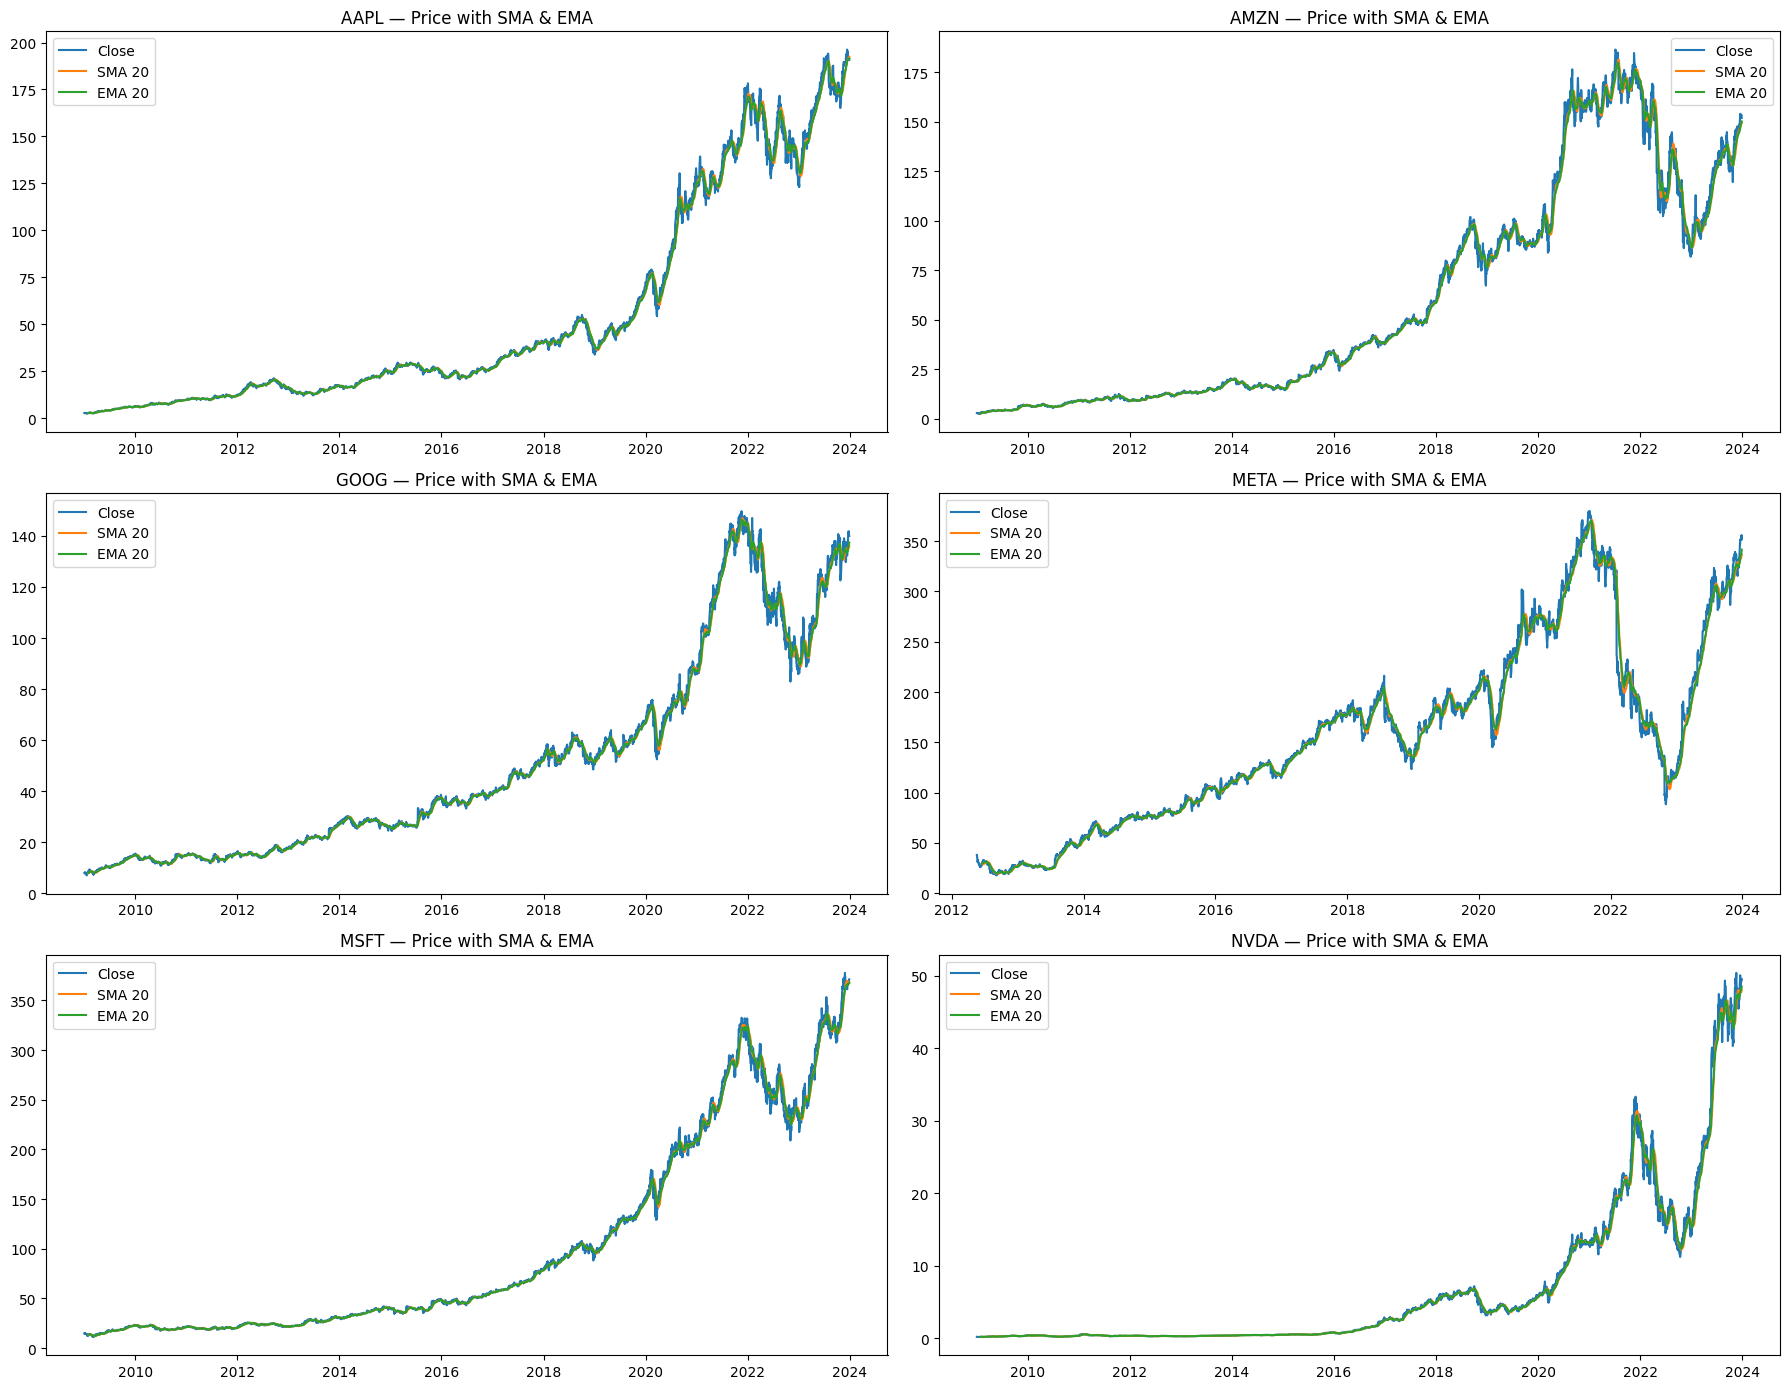

In [50]:
def plot_ma_all(processed_stocks):
    symbols = list(processed_stocks.keys())

    rows = 3
    cols = 2

    plt.figure(figsize=(18, 14))

    for i, symbol in enumerate(symbols, 1):
        df = processed_stocks[symbol]

        plt.subplot(rows, cols, i)
        plt.plot(df["close"], label="Close")
        plt.plot(df["sma_20"], label="SMA 20")
        plt.plot(df["ema_20"], label="EMA 20")
        plt.title(f"{symbol} — Price with SMA & EMA")
        plt.legend()

    plt.tight_layout()
    plt.show()

# Run it
plot_ma_all(processed_stocks)


#### RSI Plot

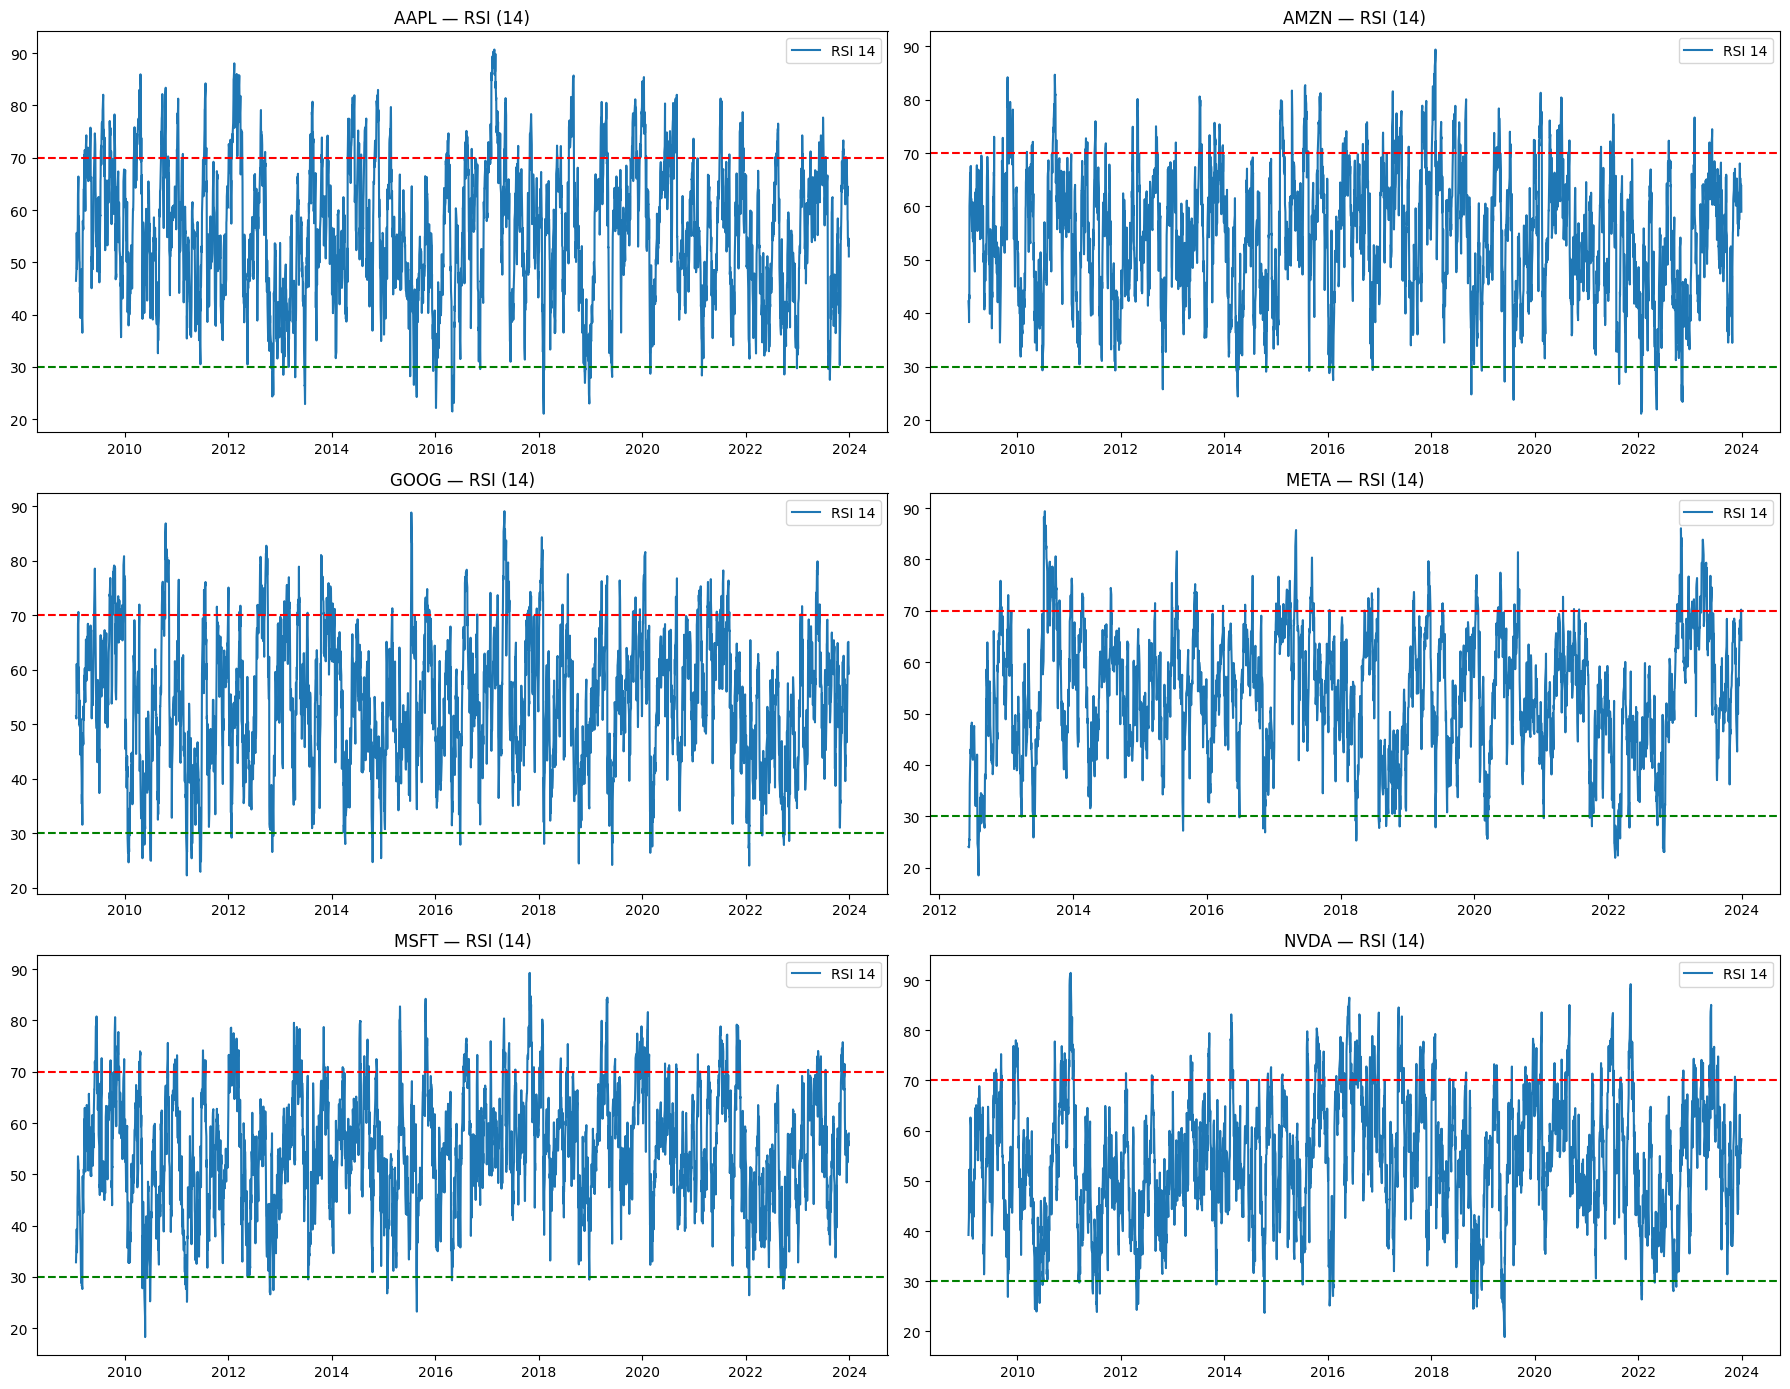

In [51]:
def plot_rsi_all(processed_stocks):
    symbols = list(processed_stocks.keys())
    rows = 3
    cols = 2

    plt.figure(figsize=(18, 14))

    for i, symbol in enumerate(symbols, 1):
        df = processed_stocks[symbol]

        plt.subplot(rows, cols, i)
        plt.plot(df["rsi_14"], label="RSI 14")
        plt.axhline(70, color='red', linestyle="--")
        plt.axhline(30, color='green', linestyle="--")
        plt.title(f"{symbol} — RSI (14)")
        plt.legend()

    plt.tight_layout()
    plt.show()

# Run the function
plot_rsi_all(processed_stocks)


#### MACD Plot

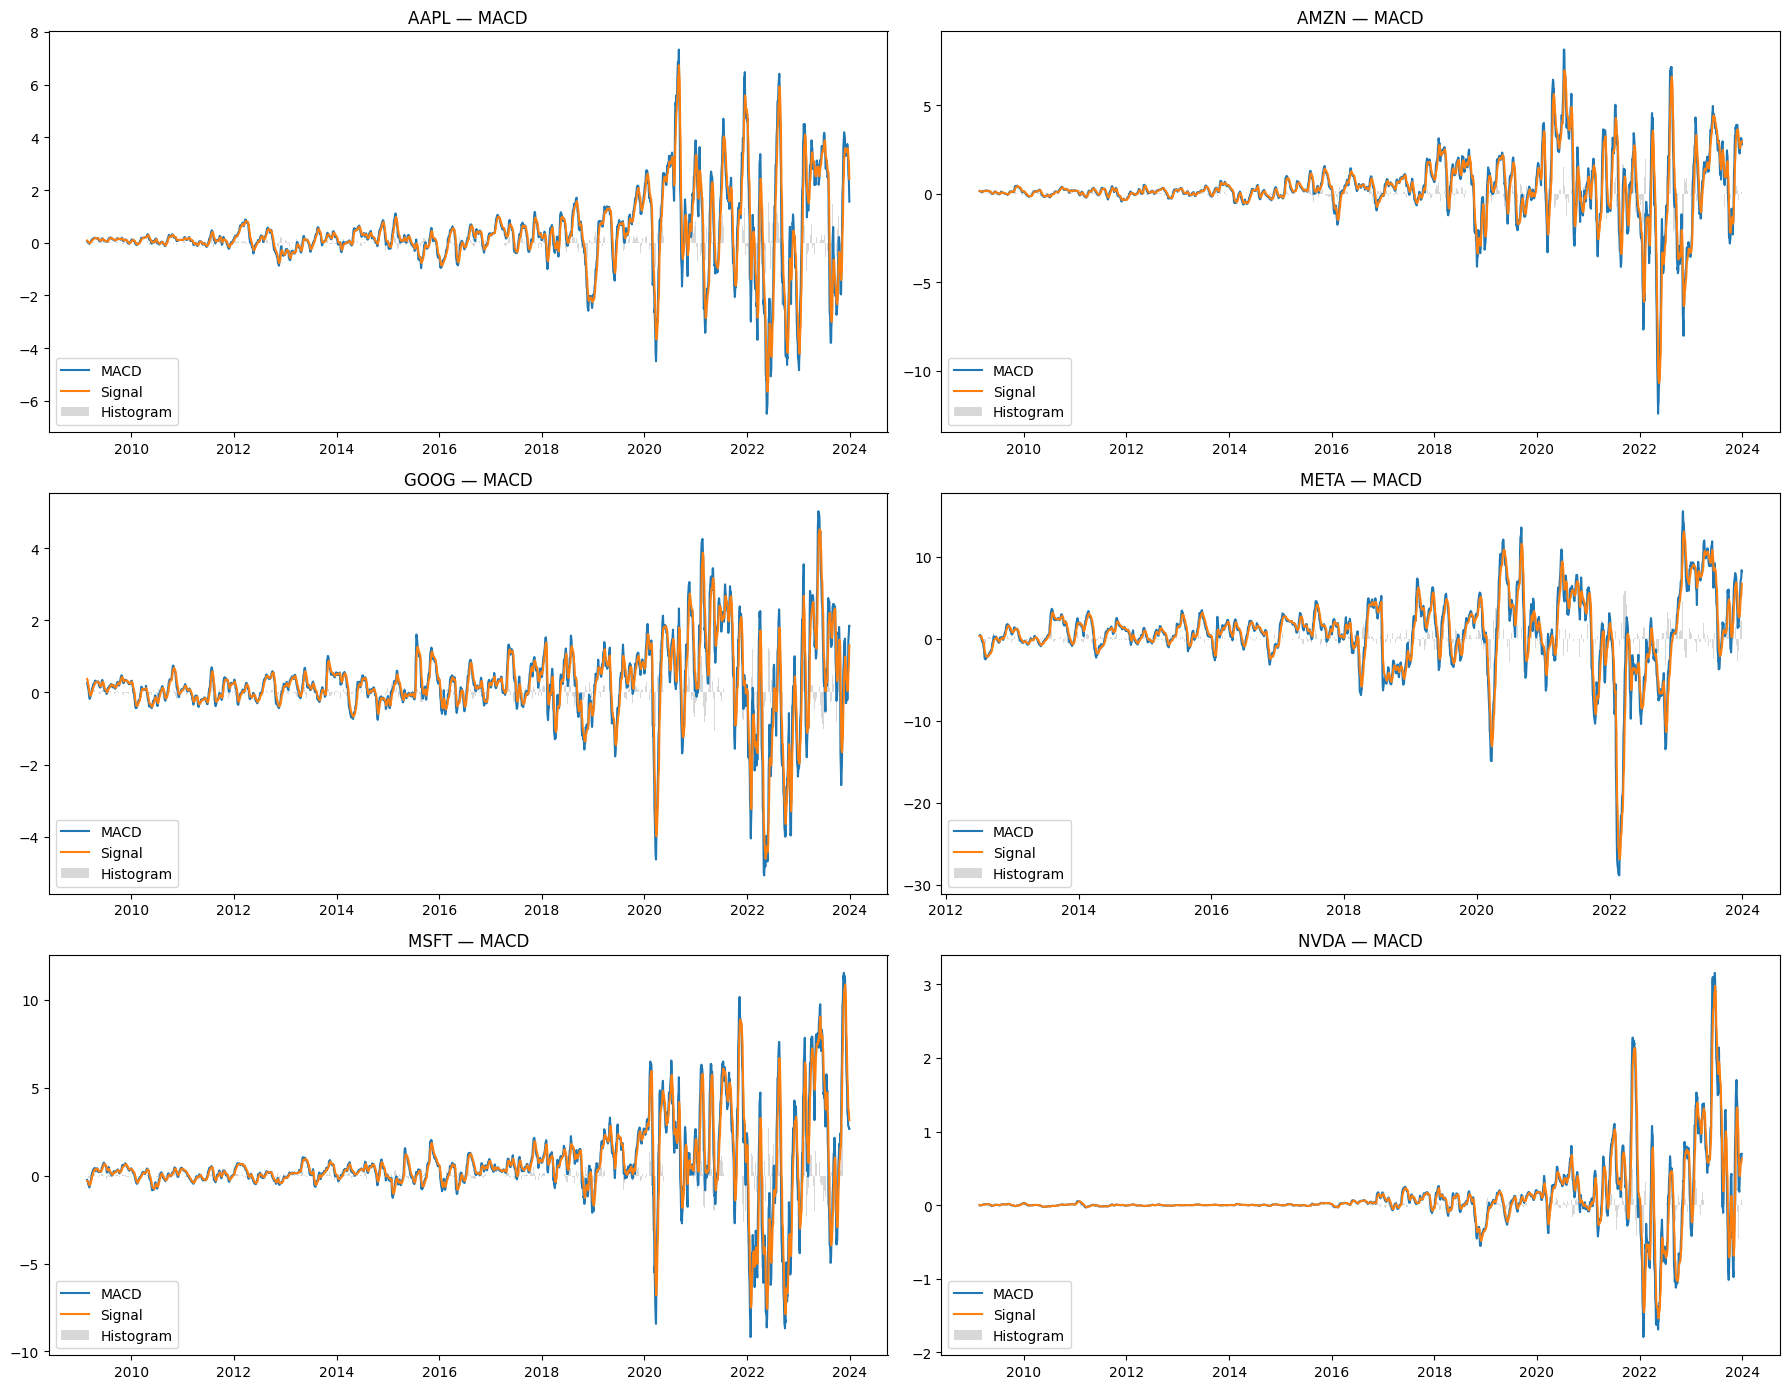

In [52]:
def plot_macd_all(processed_stocks):
    symbols = list(processed_stocks.keys())
    rows = 3
    cols = 2

    plt.figure(figsize=(18, 14))

    for i, symbol in enumerate(symbols, 1):
        df = processed_stocks[symbol]

        plt.subplot(rows, cols, i)
        plt.plot(df["macd"], label="MACD")
        plt.plot(df["macd_signal"], label="Signal")
        plt.bar(df.index, df["macd_hist"], label="Histogram", alpha=0.3, color='gray')
        plt.title(f"{symbol} — MACD")
        plt.legend()

    plt.tight_layout()
    plt.show()

# Run the function
plot_macd_all(processed_stocks)


#### Returns & Volatility

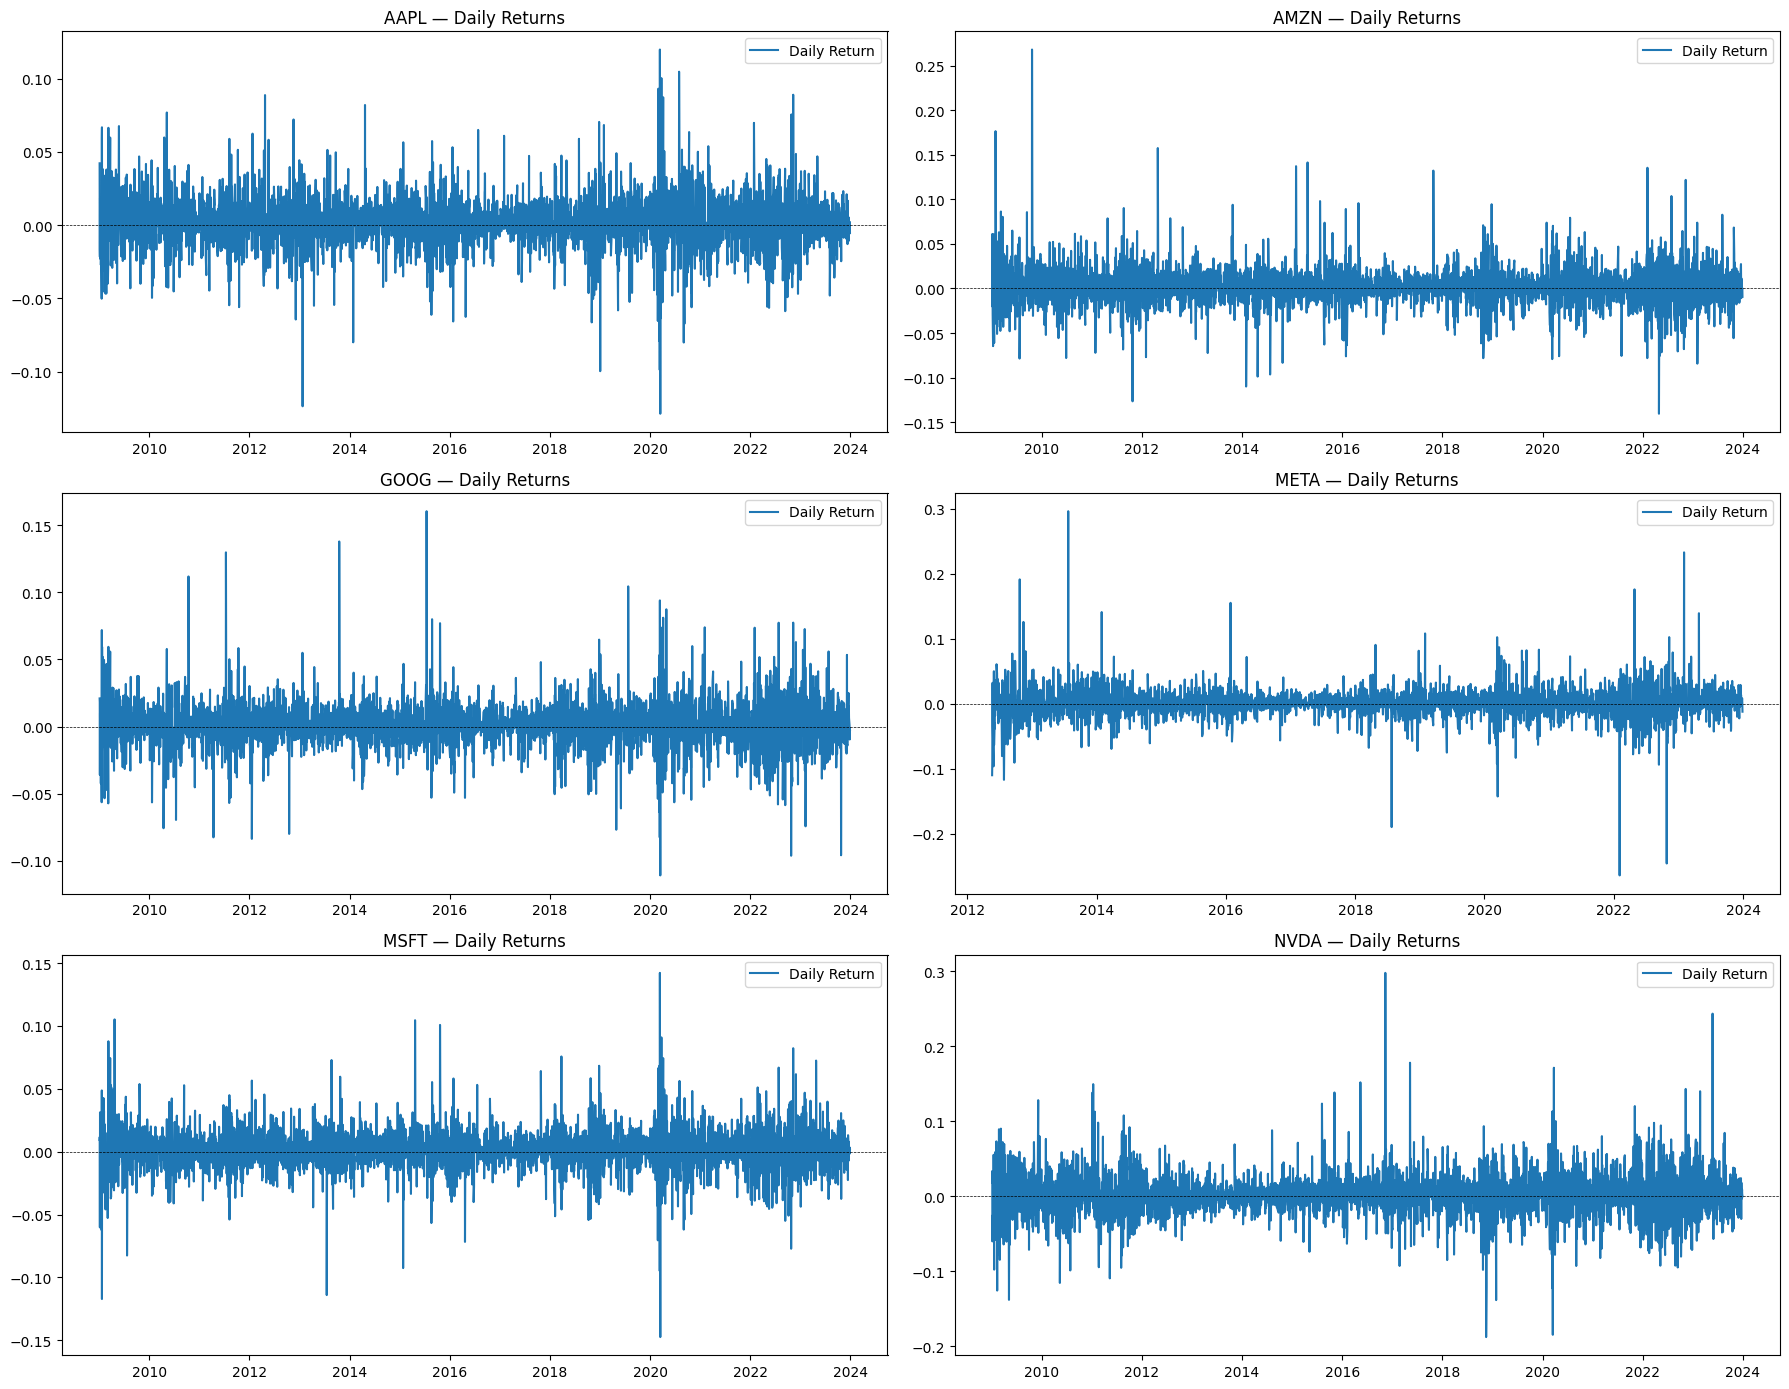

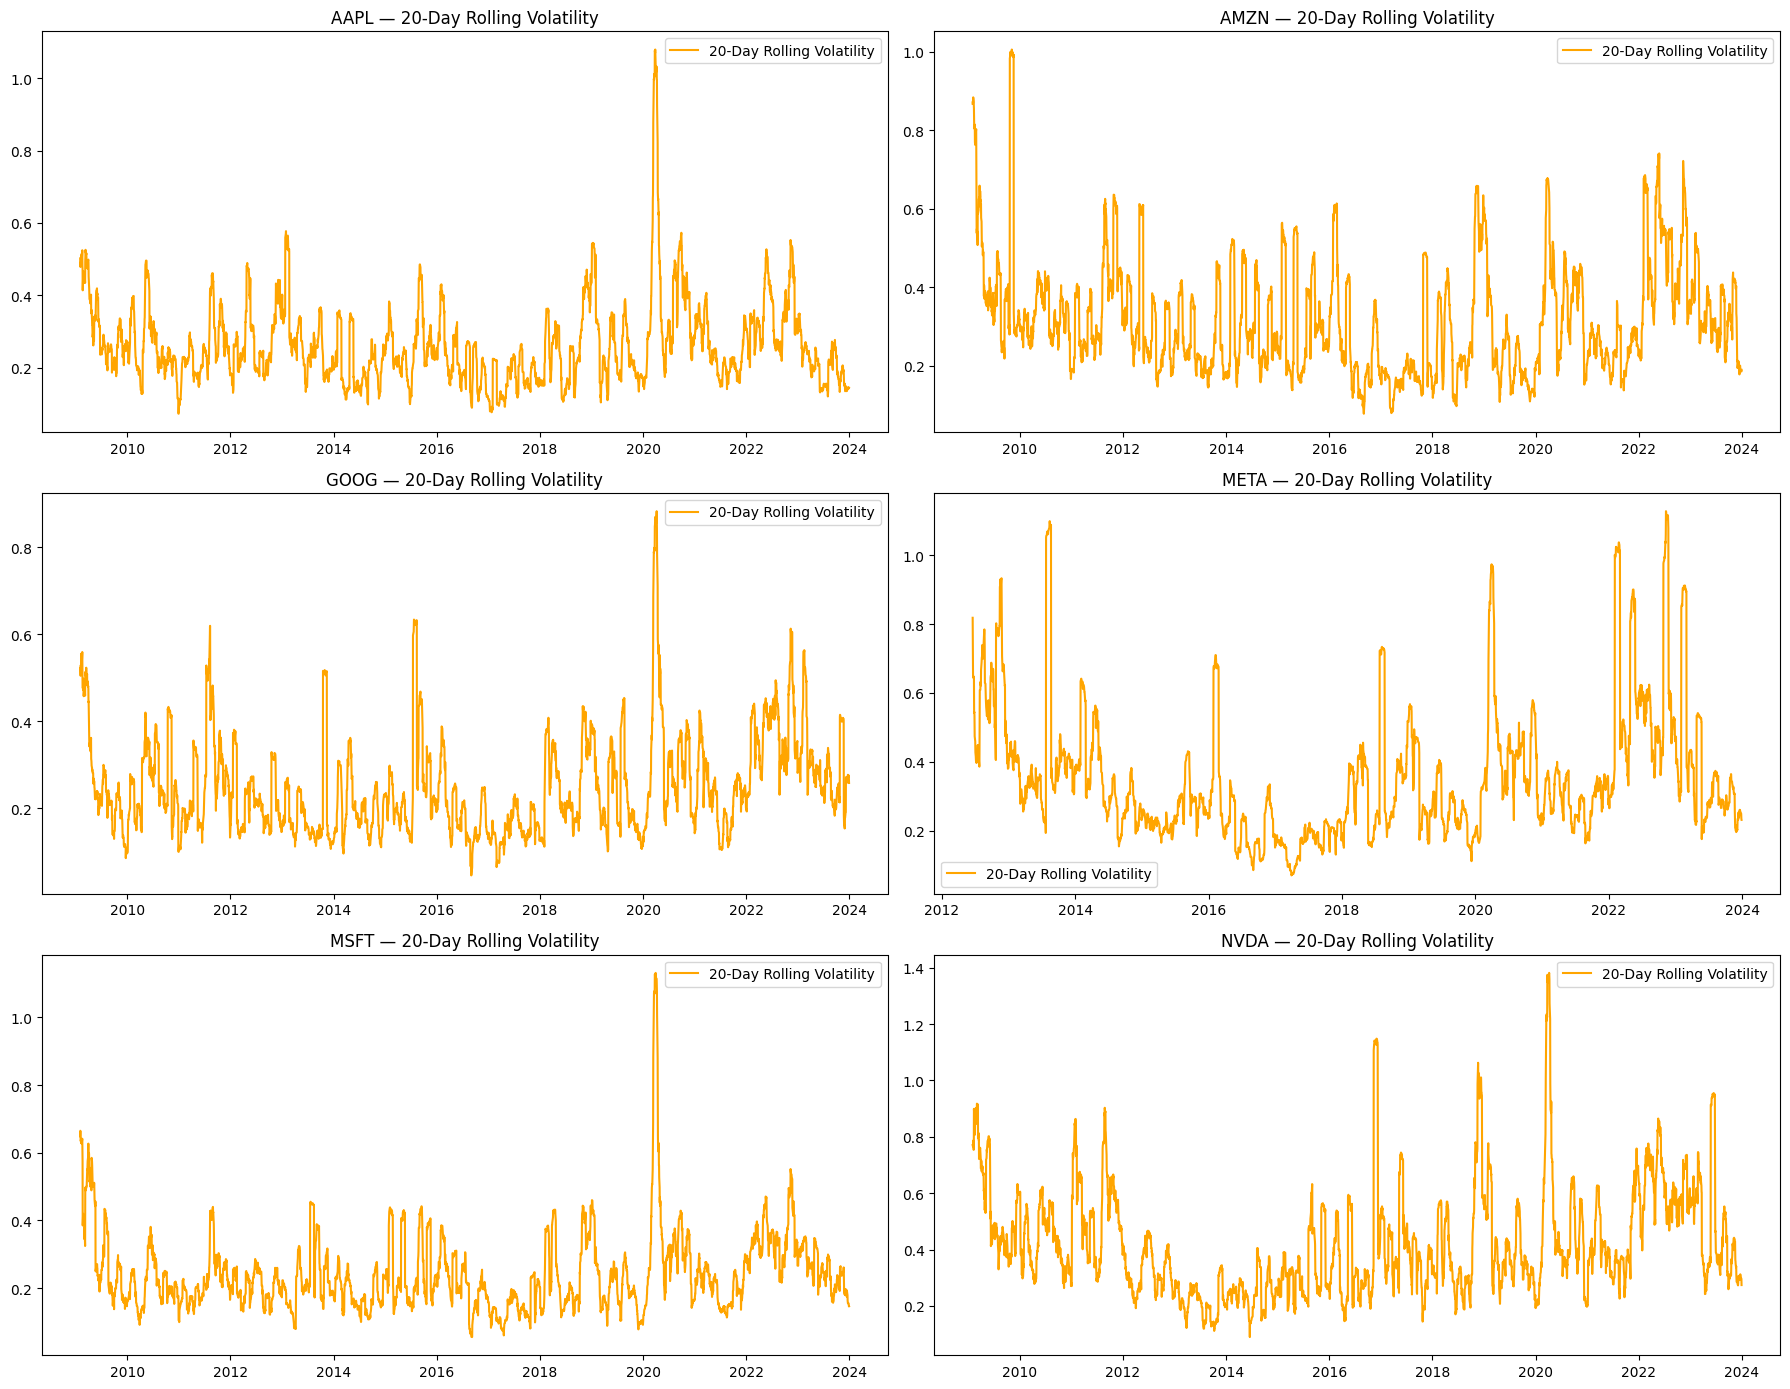

In [53]:
def plot_returns_vol_all(processed_stocks):
    symbols = list(processed_stocks.keys())
    rows = 3
    cols = 2

    # --- Canvas 1: Daily Returns ---
    plt.figure(figsize=(18, 14))
    for i, symbol in enumerate(symbols, 1):
        df = processed_stocks[symbol]
        plt.subplot(rows, cols, i)
        plt.plot(df["daily_return"], label="Daily Return")
        plt.title(f"{symbol} — Daily Returns")
        plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
        plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Canvas 2: Volatility ---
    plt.figure(figsize=(18, 14))
    for i, symbol in enumerate(symbols, 1):
        df = processed_stocks[symbol]
        plt.subplot(rows, cols, i)
        plt.plot(df["vol_20"], label="20-Day Rolling Volatility", color='orange')
        plt.title(f"{symbol} — 20-Day Rolling Volatility")
        plt.legend()
    plt.tight_layout()
    plt.show()

# Run the function
plot_returns_vol_all(processed_stocks)


### Basic Portfolio Optimization with Pynance

In [54]:
from pynance import portfolio_optimizer as po
tickers = list(processed_stocks.keys())


port = po.PortfolioCalculations(tickers)


portfolio_rr = port.max_sharpe_portfolio("rr")
print("=== Max-Sharpe Portfolio Risk/Return ===")
print(portfolio_rr)


portfolio_weights = port.max_sharpe_portfolio("df")
print("\n=== Max-Sharpe Portfolio Weights ===")
print(portfolio_weights)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\pynance\datasources\data_retriever.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adj_close_data[-1] == 0:
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\pynance\datasources\data_retriever.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adj_close_data[-1] == 0:
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\pynance\datasources\data_retriever.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labe

=== Max-Sharpe Portfolio Risk/Return ===
                   Max Sharpe Portfolio
Expected Return                  59.53%
Standard Deviation               34.16%

=== Max-Sharpe Portfolio Weights ===
     Portfolio Weight
AAPL            0.00%
AMZN            0.00%
GOOG           52.38%
META            0.00%
MSFT            0.00%
NVDA           47.62%


The portfolio favors GOOG + NVDA for maximum risk-adjusted return.

Other stocks (AAPL, AMZN, META, MSFT) were ignored because including them would reduce the Sharpe ratio.

### Summary

* Loaded and prepared stock price data for AAPL, AMZN, GOOG, META, MSFT, and NVDA.
* Calculated technical indicators using **TA-Lib**: SMA(20), EMA(20), RSI(14), MACD.
* Computed daily returns and 20-day rolling volatility using **pandas**.
* Visualized all stocks in **3×2 grids** for:

  * Price with SMA/EMA
  * RSI
  * MACD
  * Daily Returns
  * Volatility
* Used **PyNance** to perform **basic portfolio optimization**:

  * Max-Sharpe portfolio achieved an expected return of ~59.5% with 34.2% volatility.
  * Optimized portfolio weights concentrated in **GOOG (52.38%)** and **NVDA (47.62%)**.
* This analysis provides a combined view of technical indicators and portfolio-level metrics for decision-making.
